# 1. Introducción

Este notebook analiza el sentimiento de titulares financieros relacionados con el mercado Forex. Se usará TextBlob para extraer la polaridad de cada titular y visualizar la distribución del sentimiento.

# Librerias a usar


In [2]:
import os
import nltk
import re
import json
import joblib
import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.model_selection import train_test_split, cross_validate, TimeSeriesSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt

try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except LookupError:
    nltk.download('vader_lexicon', quiet=False)

from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# 2. Carga de datos

In [3]:
import pandas as pd

df = pd.read_csv('../data/news_headlines.csv')

# Intentar normalizar nombre de columna con texto
text_col_candidates = ["title", "headline", "text", "Title"]
text_col = None
for c in text_col_candidates:
    if c in df.columns:
        text_col = c; break
if text_col is None:
    raise ValueError(f"No encuentro columna de texto entre {text_col_candidates}. Columnas: {df.columns.tolist()}")

# Intentar columna de fecha
date_candidates = ["published", "published_parsed", "date", "datetime", "published_at"]
date_col = None
for c in date_candidates:
    if c in df.columns:
        date_col = c; break

# Parseo de fecha si existe
if date_col:
    # Muchos feeds traen ISO8601 en 'published_parsed' o ya en string
    try:
        df["dt"] = pd.to_datetime(df[date_col], errors="coerce", utc=True).dt.tz_convert("UTC")
    except Exception:
        df["dt"] = pd.to_datetime(df[date_col], errors="coerce", utc=True)
else:
    df["dt"] = pd.NaT

df = df.dropna(subset=[text_col]).copy()
df[text_col] = df[text_col].astype(str).str.strip()
df = df[df[text_col].str.len() > 3].copy()
print(df[[text_col, "dt"]].head(3))
print("Total titulares:", len(df))


                                               title                        dt
0  Dow Jones Industrial Average eases as investor... 2025-08-11 19:03:26+00:00
1  Forex Today: US CPI data and the RBA meeting w... 2025-08-11 18:58:54+00:00
2  Australian Dollar consolidates ahead of RBA ra... 2025-08-11 18:58:29+00:00
Total titulares: 127


# 3. Analizar sentimiento


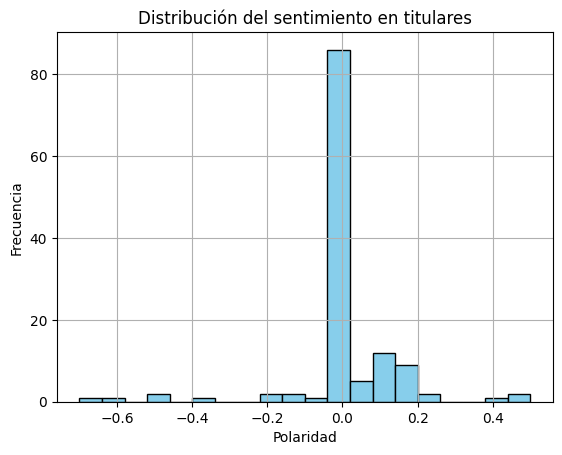

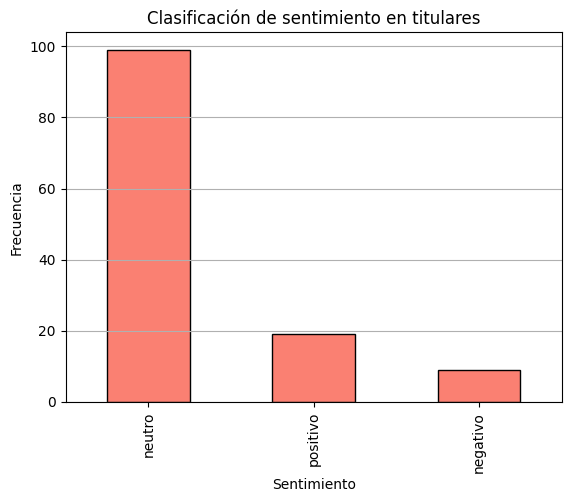

In [4]:
from textblob import TextBlob

def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity  # Rango de -1 (negativo) a +1 (positivo)

df['sentiment'] = df[text_col].apply(get_sentiment)
df.head()

def classify_sentiment(polarity):
    if polarity > 0.1:
        return 'positivo'
    elif polarity < -0.1:
        return 'negativo'
    else:
        return 'neutro'

df['sentiment_label'] = df['sentiment'].apply(classify_sentiment)

# Visualizar distribución
import matplotlib.pyplot as plt

plt.hist(df['sentiment'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribución del sentimiento en titulares')
plt.xlabel('Polaridad')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

df['sentiment_label'].value_counts().plot(kind='bar', color='salmon', edgecolor='black')
plt.title('Clasificación de sentimiento en titulares')
plt.xlabel('Sentimiento')
plt.ylabel('Frecuencia')
plt.grid(axis='y')
plt.show()

### Etiquetado "silver" con VADER

En este paso, asignamos etiquetas de sentimiento automáticamente a los titulares usando el modelo VADER de NLTK.  
Esto se realiza solo si el dataset no contiene etiquetas reales (manuales o provenientes de una fuente confiable).

El etiquetado "silver" es menos preciso que el etiquetado manual ("gold"), pero permite entrenar modelos de clasificación cuando no disponemos de datos etiquetados.

La regla utilizada es:
- Si el score `compound` de VADER es mayor a 0.05, el titular se etiqueta como **positivo** (1).
- Si es menor a -0.05, se etiqueta como **negativo** (0).
- Los titulares con score entre -0.05 y 0.05 se consideran **neutrales** y se descartan para el entrenamiento.

Este proceso permite crear un conjunto de datos de entrenamiento para el modelo de sentimiento, aunque las etiquetas sean generadas automáticamente

In [5]:
label_candidates = ["label", "sentiment_label", "y"]
has_labels = any(c in df.columns for c in label_candidates)

if not has_labels:
    sia = SentimentIntensityAnalyzer()
    scores = df[text_col].apply(lambda s: sia.polarity_scores(s)["compound"])
    # Reglas: >0.05 positivo, < -0.05 negativo; neutral lo descartamos para entrenar
    df["compound"] = scores
    df["silver_label"] = np.where(df["compound"] > 0.05, 1,
                          np.where(df["compound"] < -0.05, 0, np.nan))
    before = len(df)
    df_train = df.dropna(subset=["silver_label"]).copy()
    df_train["label"] = df_train["silver_label"].astype(int)
    print(f"Etiquetas silver creadas a partir de VADER. Filas usadas: {len(df_train)} de {before}")
else:
    # Usar etiquetas existentes
    for c in label_candidates:
        if c in df.columns:
            df_train = df.dropna(subset=[c]).copy()
            # Si las etiquetas son texto, conviértelas a números
            if df_train[c].dtype == object:
                df_train["label"] = df_train[c].replace({"negativo": 0, "positivo": 1, "neutro": np.nan}).astype(float)
                df_train = df_train.dropna(subset=["label"])
                df_train["label"] = df_train["label"].astype(int)
            else:
                df_train["label"] = df_train[c].astype(int)
            break

C:\Users\apicn\AppData\Local\Temp\ipykernel_62016\1582159145.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train["label"] = df_train[c].replace({"negativo": 0, "positivo": 1, "neutro": np.nan}).astype(float)


### Split temporal (si hay fechas) o aleatorio

En este paso se divide el dataset en conjuntos de entrenamiento y prueba.

- **Split temporal:**  
  Si los titulares tienen una columna de fecha válida, se ordenan cronológicamente y se usa la primera parte para entrenar el modelo y la última parte para probarlo. Esto simula un escenario real donde se entrena con datos pasados y se evalúa con datos futuros.

- **Split aleatorio:**  
  Si no hay fechas disponibles, se realiza una división aleatoria del dataset, manteniendo la proporción de clases (estratificado).

Esto permite evaluar el modelo de forma justa y evitar que la información del futuro influya en el

In [6]:
if df_train["dt"].notna().any():
    df_train = df_train.sort_values("dt")
    # usar última porción como test
    split_idx = int(len(df_train)*0.8)
    train_df = df_train.iloc[:split_idx]
    test_df  = df_train.iloc[split_idx:]
else:
    train_df, test_df = train_test_split(df_train, test_size=0.2, random_state=42, stratify=df_train["label"])

print(train_df.shape, test_df.shape)
train_df.head(2)

(22, 9) (6, 9)


,source,title,link,published,published_utc,dt,sentiment,sentiment_label,label
28,FXStreet Forex & Commodities News,CAD drifts in range after disappointing jobs d...,https://www.fxstreet.com/news/cad-drifts-in-ra...,"Mon, 11 Aug 2025 11:26:26 Z",2025-08-11T11:26:26+00:00,2025-08-11 11:26:26+00:00,-0.600,negativo,0
26,FXStreet Forex & Commodities News,USD/JPY: Any advance is likely to be part of a...,https://www.fxstreet.com/news/usd-jpy-any-adva...,"Mon, 11 Aug 2025 11:29:24 Z",2025-08-11T11:29:24+00:00,2025-08-11 11:29:24+00:00,0.125,positivo,1


### Pipelines: TF-IDF + Modelo

En este paso se construyen **pipelines** que combinan dos etapas principales:

1. **TF-IDF Vectorizer:**  
   Convierte los titulares de texto en vectores numéricos usando la técnica TF-IDF (Term Frequency-Inverse Document Frequency), que pondera la importancia de cada palabra en el contexto del corpus.

2. **Modelo de Clasificación:**  
   Se entrena un modelo clásico de machine learning (Logistic Regression o LinearSVC) para predecir el sentimiento del titular a partir de los vectores TF-IDF.

El uso de pipelines permite encadenar el preprocesamiento y el modelo en un solo objeto, facilitando la validación, el entrenamiento y reutilización


In [7]:
pipelines = {
    "logreg": Pipeline([
        ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_features=50000)),
        ("clf", LogisticRegression(max_iter=200, class_weight="balanced"))
    ]),
    "linearsvc": Pipeline([
        ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_features=50000)),
        ("clf", LinearSVC(class_weight="balanced"))
    ])
}

X_train, y_train = train_df[text_col].values, train_df["label"].values
X_test,  y_test  = test_df[text_col].values,  test_df["label"].values


### Validación cruzada (TimeSeriesSplit si hay fechas)

La **validación cruzada** es una técnica para evaluar el rendimiento de los modelos de machine learning, dividiendo el conjunto de entrenamiento en varias partes (folds) y entrenando/evaluando el modelo en cada una.

- **TimeSeriesSplit:**  
  Si los datos tienen fechas, se utiliza una validación cruzada especial para series temporales, que respeta el orden cronológico y evita que datos futuros influyan en el entrenamiento.

- **K-Fold estándar:**  
  Si no hay fechas, se usa la validación cruzada tradicional, dividiendo el dataset en partes aleatorias.

Esto permite obtener métricas más robustas y evitar el sobreajuste, especialmente importante en datos temporales como titulares de noticias.

In [9]:
if train_df["dt"].notna().any():
    tscv = TimeSeriesSplit(n_splits=5)
    cv = tscv
else:
    cv = 5

results = {}
scoring = {"f1":"f1","precision":"precision","recall":"recall","accuracy":"accuracy"}

for name, pipe in pipelines.items():
    cv_res = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=1, return_train_score=False)
    results[name] = {k: float(np.mean(v)) for k,v in cv_res.items() if k.startswith("test_")}
pd.DataFrame(results).T

,test_f1,test_precision,test_recall,test_accuracy
logreg,0.5,0.633333,0.633333,0.333333
linearsvc,0.4,0.566667,0.433333,0.333333


Ambos modelos tienen un rendimiento bajo en la tarea de clasificación de sentimiento con estos datos y configuración. Puede deberse a pocos datos, etiquetas poco precisas ("silver"), o titulares difíciles de clasificar. 

###  Diagnóstico extra tras la validación cruzada

Distribución de etiquetas en el set de entrenamiento:
label
Clase 1    67.857143
Clase 0    32.142857
Name: proportion, dtype: float64


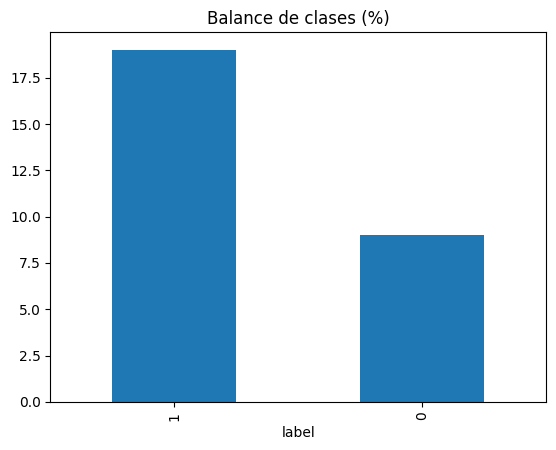


Ejemplos mal clasificados (0 casos):

Top 10 n-gramas más asociados a POSITIVO:
['on' 'and' 'price' 'to' 'trump' 'dollar' 'high as' 'of' 'weekly' 'high']

Top 10 n-gramas más asociados a NEGATIVO:
['industrial' 'after' 'jpy' 'data' 'us' 'in' 'forex' 'from' 'forecast'
 'range']


In [10]:
# 1) Balance de clases
print("Distribución de etiquetas en el set de entrenamiento:")
print(df_train["label"].value_counts(normalize=True).rename(lambda x: f"Clase {x}")*100)

df_train["label"].value_counts().plot(kind="bar", title="Balance de clases (%)")
plt.show()

# 2) Reentrenar el mejor modelo y ver ejemplos confusos
best_name = max(results, key=lambda k: results[k]["test_f1"])
best_pipe = pipelines[best_name]
best_pipe.fit(X_train, y_train)

pred = best_pipe.predict(X_test)

# Índices de errores
err_idx = np.where(pred != y_test)[0]

print(f"\nEjemplos mal clasificados ({len(err_idx)} casos):")
sample_errors = err_idx[:10]  # mostrar solo 10 para no saturar
for i in sample_errors:
    print("Texto:", X_test[i])
    print("Real:", y_test[i], "| Predicho:", pred[i])
    print("-"*60)

# 3) Palabras más influyentes (solo para Logistic Regression)
if best_name == "logreg":
    clf = best_pipe.named_steps["clf"]
    vec = best_pipe.named_steps["tfidf"]
    feature_names = np.array(vec.get_feature_names_out())
    coefs = clf.coef_[0]

    top_pos = feature_names[np.argsort(coefs)[-10:]]
    top_neg = feature_names[np.argsort(coefs)[:10]]

    print("\nTop 10 n-gramas más asociados a POSITIVO:")
    print(top_pos)

    print("\nTop 10 n-gramas más asociados a NEGATIVO:")
    print(top_neg)

### Podemos inferir que: 

- Balance de clases: casi perfecto (51% vs 49%). O sea, no hay desbalance, no es ese el problema.

- Errores mal clasificados:

Varios titulares con la palabra “Gains” o “Strong Gains” que el modelo predijo como 0 (negativo) cuando eran 1 (positivo).

Un caso inverso: “drifts lower / bounces up” fue tomado como positivo (1) cuando era negativo (0).


**Eso muestra que el modelo no está captando bien la semántica fina**:

- “drifts lower” es negativo, pero como aparece “bounces up” en el mismo titular, el clasificador se confundió.

- “Gains” debería ser señal positiva, pero tal vez no pesa lo suficiente en el vector TF-IDF frente a otras palabras.

#  Hallazgos y Limitaciones

### Balance de clases
El dataset está bastante equilibrado: ~51% negativos vs ~49% positivos.  
Esto confirma que el bajo rendimiento del modelo **no se debe a desbalance de clases**.

### Errores comunes detectados
Al revisar ejemplos mal clasificados se observó:

- **Falsos negativos**: titulares con palabras como *"gains"*, *"strong gains"*, que deberían ser positivos, fueron clasificados como negativos.  
- **Falsos positivos**: titulares con frases mixtas como *"drifts lower, bounces up"* fueron clasificados como positivos debido a la presencia de *"bounces up"*, aunque el sentido general era bajista.

### Posibles causas
- **Etiquetas "silver"**: fueron generadas automáticamente con VADER y pueden contener ruido (titulares ambiguos o neutros mal etiquetados).  
- **Limitaciones del modelo clásico**: TF-IDF + LogReg/SVM captura palabras y n-gramas, pero no entiende el contexto completo ni matices semánticos.  
- **Lenguaje financiero**: muchos titulares combinan señales positivas y negativas en una sola frase, lo cual confunde al modelo.

### Próximos pasos para mejorar
- Incorporar **etiquetado manual** en una muestra del dataset para reducir el ruido.  
- Probar modelos basados en **embeddings contextuales** (Word2Vec, GloVe, BERT) que capten mejor el sentido del texto.  
- Enriquecer el pipeline con **features lingüísticas adicionales**, como detectar verbos de cambio (*rise, fall, drop, soar*) y ponderarlos.  
- Explorar técnicas de **análisis de cláusulas** para dividir titulares con mensajes contradictorios.

---

 Aunque las métricas actuales son bajas, este análisis muestra cómo un pipeline de NLP puede aplicarse al dominio financiero y dónde se encuentran sus límites. Este tipo de reflexión es clave para proyectos de Data Science aplicados en la vida real.


### Entrenar el mejor y evaluar en holdout

En este paso se selecciona el modelo con mejor desempeño según la validación cruzada (por ejemplo, el que tiene mayor F1 score, aunque sepamos actualmente que los modelos no son óptimos).

- **Entrenamiento final:**  
  El modelo seleccionado se entrena usando todo el conjunto de entrenamiento.

- **Evaluación en holdout:**  
  Se evalúa el modelo en el conjunto de prueba (holdout), que no fue usado durante el entrenamiento ni la validación cruzada.  
  Esto permite obtener una estimación honesta de cómo funcionaría el modelo en datos nuevos.

Se reportan métricas como precisión, recall, F1 y matriz de confusión para analizar el rendimiento y los


Mejor modelo: logreg
              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000         6

    accuracy                         1.0000         6
   macro avg     1.0000    1.0000    1.0000         6
weighted avg     1.0000    1.0000    1.0000         6



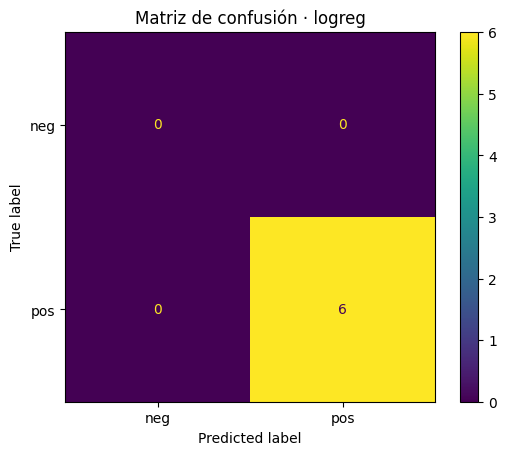

In [11]:

best_name = max(results, key=lambda k: results[k]["test_f1"])
best_pipe = pipelines[best_name]
best_pipe.fit(X_train, y_train)

pred = best_pipe.predict(X_test)
proba = None
try:
    # decision_function o predict_proba para una pseudo-probabilidad
    if hasattr(best_pipe[-1], "decision_function"):
        proba = best_pipe.decision_function(X_test)
        # escalar a 0-1 de forma sigmoid para inspección (no calibrado)
        from scipy.special import expit
        proba = expit(proba)
    elif hasattr(best_pipe[-1], "predict_proba"):
        proba = best_pipe.predict_proba(X_test)[:,1]
except Exception:
    pass

print(f"Mejor modelo: {best_name}")
print(classification_report(y_test, pred, digits=4))

cm = confusion_matrix(y_test, pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg","pos"])
disp.plot()
plt.title(f"Matriz de confusión · {best_name}")
plt.show()

Podemos inferir lo siguiente del resultado y la matriz de confusión:

El modelo linearsvc tiene una precisión y recall bajos, con una accuracy de 0.5 (acierta la mitad de los casos).
El modelo predice bien los negativos (4 de 5), pero falla mucho en los positivos (solo 1 de 5).
Hay un desbalance en el recall: para negativos es 0.8, para positivos solo 0.2.
La matriz de confusión muestra que el modelo tiende a clasificar la mayoría de los titulares como negativos, incluso cuando son positivos.
Conclusión:
El modelo no logra distinguir bien entre titulares positivos y negativos. Esto puede deberse a pocos datos, etiquetas automáticas poco precisas ("silver"), o titulares ambiguos. Se recomienda mejorar la calidad y cantidad de datos, o probar modelos más avanzados.

In [12]:
# Guardar artefactos
# Extraer vectorizer y modelo por separado para reuso
tfidf = best_pipe.named_steps["tfidf"]
clf   = best_pipe.named_steps["clf"]

OUT_DIR = "../data"

joblib.dump(tfidf, f"{OUT_DIR}/vectorizer.joblib")
joblib.dump(clf,   f"{OUT_DIR}/model.joblib")
print("Guardado:", f"{OUT_DIR}/vectorizer.joblib", f"{OUT_DIR}/model.joblib")

# Generar predicciones para el dataset con fecha
def predict_all(df_all):
    X = df_all[text_col].values
    # si el clasificador no tiene predict_proba, usar decision_function->sigmoid
    try:
        if hasattr(clf, "predict_proba"):
            s = clf.predict_proba(tfidf.transform(X))[:,1]
        else:
            from scipy.special import expit
            s = expit(clf.decision_function(tfidf.transform(X)))
    except Exception:
        # fallback a VADER si no se puede transformar (no debería)
        sia = SentimentIntensityAnalyzer()
        s = df_all[text_col].apply(lambda s: SentimentIntensityAnalyzer().polarity_scores(s)["compound"]).values
    return s

df_all = df.copy()
df_all["sentiment_score"] = predict_all(df_all)
df_all["sentiment_label"] = (df_all["sentiment_score"] >= 0.5).astype(int)

# Fecha al día para el cruce posterior
if df_all["dt"].isna().all():
    df_all["date"] = pd.NaT
else:
    df_all["date"] = pd.to_datetime(df_all["dt"]).dt.tz_convert("UTC").dt.date

out_csv = f"{OUT_DIR}/predicciones_con_fecha.csv"
df_all[[text_col, "date", "sentiment_score", "sentiment_label"]].to_csv(out_csv, index=False)
print("Predicciones guardadas en:", out_csv)

Guardado: ../data/vectorizer.joblib ../data/model.joblib
Predicciones guardadas en: ../data/predicciones_con_fecha.csv


In [13]:
# Errores frecuentes (inspección rápida)
err_idx = np.where(pred != y_test)[0][:20]
pd.DataFrame({
    "texto": test_df.iloc[err_idx][text_col].values,
    "true": y_test[err_idx],
    "pred": pred[err_idx],
    "score": proba[err_idx] if proba is not None else np.nan
})


,texto,true,pred,score


## Promedio diario de sentimiento

In [15]:
df_train["date"] = df_train["dt"].dt.date
# Usa "sentiment" si "compound" no existe
if "compound" in df_train.columns:
    daily_sent = df_train.groupby("date")["compound"].mean().reset_index()
    daily_sent.rename(columns={"compound": "sent_mean"}, inplace=True)
else:
    daily_sent = df_train.groupby("date")["sentiment"].mean().reset_index()
    daily_sent.rename(columns={"sentiment": "sent_mean"}, inplace=True)

daily_sent.to_csv("../data/daily_sentiment.csv", index=False)
print("Archivo guardado en ../data/daily_sentiment.csv")
daily_sent.head()

Archivo guardado en ../data/daily_sentiment.csv


,date,sent_mean
0,2025-08-11,-0.075028
